## Beginning of Code if the df is already there

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_reader = pd.read_json('quotes-2020-domains.json.bz2', lines=True, compression='bz2', chunksize=10000)

signal_Joe_Biden = np.zeros([53,]) # 53 weeks in 2020 because of leap year
signal_Donald_Trump = np.zeros([53,]) # 53 weeks in 2020 because of leap year
num_chunk = 0
for chunk in df_reader:
    num_chunk += 1

    chunk_Joe_Biden = chunk[chunk.speaker == "Joe Biden"]
    weeks_Joe_Biden = chunk_Joe_Biden.date.apply(lambda x: x.week).values
    hist_Joe_Biden, _ = np.histogram(weeks_Joe_Biden, range(1, signal_Joe_Biden.shape[0]+2))
    signal_Joe_Biden += hist_Joe_Biden

    chunk_Donald_Trump = chunk[chunk.speaker.isin(('Donald Trump', 'President Trump', 'President Donald Trump'))] # Different ways to call him in the df
    weeks_Donald_Trump = chunk_Donald_Trump.date.apply(lambda x: x.week).values
    hist_Donald_Trump, _ = np.histogram(weeks_Donald_Trump, range(1, signal_Donald_Trump.shape[0]+2))
    signal_Donald_Trump += hist_Donald_Trump

    # if num_chunk == 10:
      # break

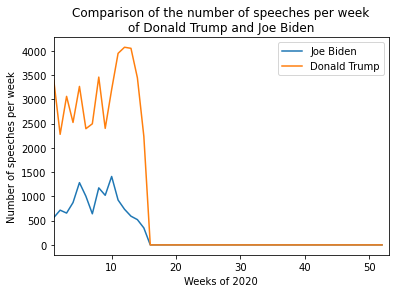

In [4]:
plt.plot(signal_Joe_Biden, label="Joe Biden")
plt.plot(signal_Donald_Trump, label="Donald Trump")
plt.xlim(1,signal_Donald_Trump.shape[0])
plt.xlabel("Weeks of 2020")
plt.ylabel("Number of speeches per week")
plt.title("Comparison of the number of speeches per week\nof Donald Trump and Joe Biden")
plt.legend();

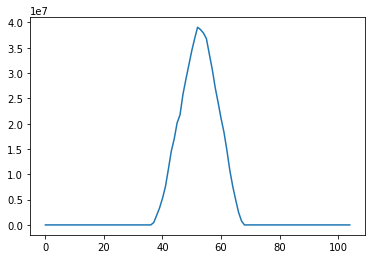

In [5]:
plt.plot(np.correlate(signal_Donald_Trump, signal_Joe_Biden, 'full')); # TODO get better interpetations